<a href="https://colab.research.google.com/github/RMichae1/PyroStudies/blob/master/Bayesian_Imputation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook found here to demonstrate error while predicting with new missing values

https://github.com/RMichae1/PyroStudies/blob/master/Bayesian_Imputation.ipynb

In [1]:
#!pip install numpyro

In [2]:
import numpy as np
from numpy.random import random as np_random
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

from jax import ops, random
from jax.scipy.special import expit
import jax.numpy as jnp
from numpyro.diagnostics import hpdi

/usr/local/anaconda3/envs/ab_test_script/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/usr/local/anaconda3/envs/ab_test_script/lib/python3.8/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


In [3]:
iris_data = datasets.load_iris() 

In [4]:
iris_df = pd.DataFrame(data=np.c_[iris_data['data'], iris_data['target']],
                      columns=iris_data['feature_names'] + ['target'])
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


In [5]:
iris_df["target"] = iris_df.target.astype("int")
# select 2 species for ease of use
iris_df = iris_df[iris_df.target.isin([0, 1])]
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,1
96,5.7,2.9,4.2,1.3,1
97,6.2,2.9,4.3,1.3,1
98,5.1,2.5,3.0,1.1,1


In [6]:
random_vec = np_random(iris_df["petal length (cm)"].shape)<0.5
iris_df["petal length (cm)"] = iris_df["petal length (cm)"].where(random_vec, 
                                                                  other=np.nan)
iris_df

/var/folders/rx/593h0xvn7r3cvdwpbnnwrky00000gn/T/ipykernel_59723/394653564.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iris_df["petal length (cm)"] = iris_df["petal length (cm)"].where(random_vec,


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,NaN,0.2,0
2,4.7,3.2,NaN,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
95,5.7,3.0,NaN,1.2,1
96,5.7,2.9,4.2,1.3,1
97,6.2,2.9,4.3,1.3,1
98,5.1,2.5,NaN,1.1,1


/usr/local/anaconda3/envs/ab_test_script/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sepal length (cm)', ylabel='sepal width (cm)'>

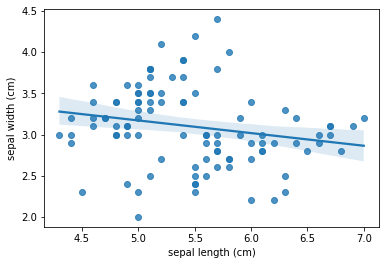

In [7]:
sns.regplot("sepal length (cm)", "sepal width (cm)", iris_df)

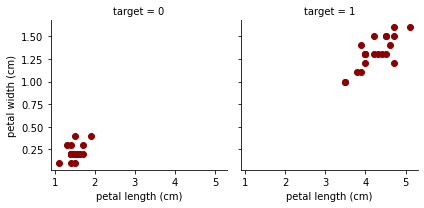

In [8]:
t = sns.FacetGrid(iris_df, col="target")
t.map(plt.scatter, "petal length (cm)", "petal width (cm)", color="darkred")
plt.savefig("./lr_lw.png")

/usr/local/anaconda3/envs/ab_test_script/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


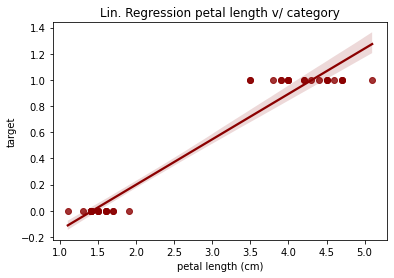

In [9]:
sns.regplot("petal length (cm)", "target", color="darkred", data=iris_df)
plt.title("Lin. Regression petal length v/ category")
plt.savefig("./lr_target_p_len.png")

In [10]:
iris_data=dict(s_len=iris_df["sepal length (cm)"].values,
              s_width=iris_df["sepal width (cm)"].values,
              p_len=iris_df["petal length (cm)"].values,
              p_width=iris_df["petal width (cm)"].values,
              target=iris_df.target.values)
iris_data

{'s_len': array([5.1, 4.9, 4.7, 4.6, 5. , 5.4, 4.6, 5. , 4.4, 4.9, 5.4, 4.8, 4.8,
        4.3, 5.8, 5.7, 5.4, 5.1, 5.7, 5.1, 5.4, 5.1, 4.6, 5.1, 4.8, 5. ,
        5. , 5.2, 5.2, 4.7, 4.8, 5.4, 5.2, 5.5, 4.9, 5. , 5.5, 4.9, 4.4,
        5.1, 5. , 4.5, 4.4, 5. , 5.1, 4.8, 5.1, 4.6, 5.3, 5. , 7. , 6.4,
        6.9, 5.5, 6.5, 5.7, 6.3, 4.9, 6.6, 5.2, 5. , 5.9, 6. , 6.1, 5.6,
        6.7, 5.6, 5.8, 6.2, 5.6, 5.9, 6.1, 6.3, 6.1, 6.4, 6.6, 6.8, 6.7,
        6. , 5.7, 5.5, 5.5, 5.8, 6. , 5.4, 6. , 6.7, 6.3, 5.6, 5.5, 5.5,
        6.1, 5.8, 5. , 5.6, 5.7, 5.7, 6.2, 5.1, 5.7]),
 's_width': array([3.5, 3. , 3.2, 3.1, 3.6, 3.9, 3.4, 3.4, 2.9, 3.1, 3.7, 3.4, 3. ,
        3. , 4. , 4.4, 3.9, 3.5, 3.8, 3.8, 3.4, 3.7, 3.6, 3.3, 3.4, 3. ,
        3.4, 3.5, 3.4, 3.2, 3.1, 3.4, 4.1, 4.2, 3.1, 3.2, 3.5, 3.6, 3. ,
        3.4, 3.5, 2.3, 3.2, 3.5, 3.8, 3. , 3.8, 3.2, 3.7, 3.3, 3.2, 3.2,
        3.1, 2.3, 2.8, 2.8, 3.3, 2.4, 2.9, 2.7, 2. , 3. , 2.2, 2.9, 2.9,
        3.1, 3. , 2.7, 2.2, 2.5, 3.2, 2.8, 2.5, 2

In [11]:
print("Petal Length μ = {}".format(iris_df["petal length (cm)"].mean()))
print("Petal Length σ^2 = {}".format(iris_df["petal length (cm)"].std()))

Petal Length μ = 2.9000000000000004
Petal Length σ^2 = 1.4240786495134317


In [12]:
p_len = iris_df["petal length (cm)"]
print("Amount missing: {}".format(len(np.array(np.isnan(p_len).astype(int)).nonzero()[0])))
np.array(np.isnan(p_len).astype(int)).nonzero()[0]

Amount missing: 59


array([ 1,  2,  5,  6,  9, 10, 14, 16, 19, 21, 22, 23, 24, 25, 26, 27, 31,
       33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 45, 47, 48, 50, 52, 54, 57,
       58, 62, 63, 64, 65, 67, 68, 70, 72, 74, 75, 76, 77, 78, 81, 82, 84,
       85, 88, 90, 93, 94, 95, 98, 99])

In [13]:
def model(s_len, s_width, p_len, p_width, target=None):
    b_s_len = numpyro.sample("b_s_len", dist.Normal(0,1))
    b_s_width = numpyro.sample("b_s_width", dist.Normal(0,1))
    b_p_width = numpyro.sample("b_p_width", dist.Normal(0,1))
    
    # impute length
    len_mu = numpyro.sample("p_length_mu", dist.Normal(3, 0.02))
    len_sigma = abs(numpyro.sample("p_length_sigma", dist.Normal(1, 0.02)))
    len_is_nan = np.isnan(p_len)
    len_nan_idx = np.array(np.isnan(p_len).astype(int)).nonzero()[0]

    len_impute = numpyro.sample("len_impute", 
                                dist.Normal(len_mu, len_sigma).expand([len(len_nan_idx)]).mask(False))

    p_len = ops.index_update(p_len, len_nan_idx, len_impute)
    
    numpyro.sample("p_length", dist.Normal(len_mu, len_sigma), obs=p_len)
    
    l = numpyro.sample("l", dist.Normal(0, 1))
    b_len = numpyro.sample("b_length", dist.Normal(0, 1))
    logits = l + b_len * p_len
    
    logits = logits + b_s_len*s_len + b_s_width*s_width + b_p_width*p_width
    
    if target is None:
        # prediction case
        probs = expit(logits)
        numpyro.sample("probs", dist.Delta(probs))

    numpyro.sample("target", dist.Bernoulli(logits=logits), obs=target)

In [14]:
mcmc = MCMC(NUTS(model=model), num_warmup=5000, num_samples=10000, num_chains=1)
mcmc.run(random.PRNGKey(42), **iris_data)

mcmc.print_summary()

sample: 100%|█| 15000/15000 [00:13<00:00, 1086.17it/s, 63 steps of size 8.75e-02



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
        b_length      0.30      0.38      0.29     -0.33      0.91  17047.78      1.00
       b_p_width      3.06      0.76      3.06      1.82      4.28  14339.55      1.00
         b_s_len      0.91      0.47      0.91      0.13      1.68  12674.08      1.00
       b_s_width     -2.54      0.66     -2.54     -3.66     -1.51  12633.99      1.00
               l     -0.37      0.95     -0.38     -1.91      1.23  22291.50      1.00
   len_impute[0]      2.95      0.99      2.95      1.28      4.53  20631.41      1.00
   len_impute[1]      2.96      1.01      2.97      1.19      4.49  20962.27      1.00
   len_impute[2]      2.97      1.01      2.97      1.34      4.63  21862.72      1.00
   len_impute[3]      2.96      1.00      2.97      1.30      4.60  21497.25      1.00
   len_impute[4]      2.96      1.00      2.95      1.39      4.66  21446.12      1.00
   len_impute[5]      2.99      1.03      

In [15]:
samples = mcmc.get_samples()

In [16]:
samples

{'b_length': DeviceArray([ 0.44431582, -0.08189383,  0.44928363, ...,  0.5781235 ,
               0.3794596 ,  0.11574154], dtype=float32),
 'b_p_width': DeviceArray([3.3113532, 3.620144 , 2.6087162, ..., 3.9792106, 1.6353911,
              3.1595387], dtype=float32),
 'b_s_len': DeviceArray([0.4195448, 0.8315207, 0.7208075, ..., 1.0802108, 1.4596807,
              1.2845807], dtype=float32),
 'b_s_width': DeviceArray([-2.2818031, -1.7299668, -2.930904 , ..., -3.0866904,
              -3.2216518, -2.7198136], dtype=float32),
 'l': DeviceArray([ 0.85684067, -2.0679152 ,  1.6382585 , ..., -0.6999481 ,
               0.68069357, -0.4807031 ], dtype=float32),
 'len_impute': DeviceArray([[4.3595834, 2.9401002, 3.1836963, ..., 2.6326299, 3.0311139,
               3.727669 ],
              [2.312108 , 3.68303  , 2.921833 , ..., 3.4393516, 2.5736697,
               2.0491157],
              [3.9607534, 2.4196482, 2.9523137, ..., 2.6020393, 3.1437328,
               4.027034 ],
              ..

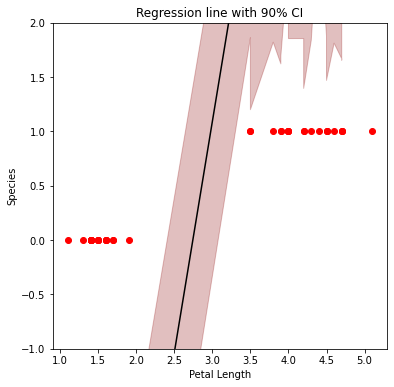

In [17]:
def plot_regression(x, y_mean, y_hpdi):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    petal_length = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    species = iris_df.target.values[idx]

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(petal_length, mean, 'k')
    ax.plot(petal_length, species, 'ro')
    ax.fill_between(petal_length, hpdi[0], hpdi[1], alpha=0.25, color="darkred", interpolate=False)
    return ax

# Compute empirical posterior distribution over mu
posterior_mu = jnp.expand_dims(samples['l'], -1) + \
               jnp.expand_dims(samples['b_length'], -1) * iris_df["petal length (cm)"].values + \
               jnp.expand_dims(samples['b_s_len'], -1)*iris_df["sepal length (cm)"].values + \
               jnp.expand_dims(samples['b_s_width'], -1)*iris_df["sepal width (cm)"].values + \
               jnp.expand_dims(samples['b_p_width'], -1)*iris_df["petal width (cm)"].values

mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.95)
ax = plot_regression(iris_df["petal length (cm)"].values, mean_mu, hpdi_mu)
ax.set(xlabel='Petal Length', ylabel='Species', title='Regression line with 90% CI')
ax.set_ylim([-1, 2]);
plt.savefig("rp_sampled_90CI.png")

In [18]:
iris_data = datasets.load_iris() 

In [19]:
iris_df = pd.DataFrame(data=np.c_[iris_data['data'], iris_data['target']],
                      columns=iris_data['feature_names'] + ['target'])
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


In [20]:
iris_df["target"] = iris_df.target.astype("int")
# select 2 species for ease of use
iris_df = iris_df[iris_df.target.isin([0, 1])]
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,1
96,5.7,2.9,4.2,1.3,1
97,6.2,2.9,4.3,1.3,1
98,5.1,2.5,3.0,1.1,1


In [21]:
np_random(iris_df["petal length (cm)"].shape)<0.5

array([ True,  True, False, False, False,  True,  True,  True,  True,
       False, False, False, False,  True,  True,  True,  True, False,
        True,  True, False,  True,  True, False,  True,  True, False,
        True,  True, False, False,  True,  True, False, False, False,
       False,  True,  True,  True,  True,  True, False,  True,  True,
       False, False,  True, False, False,  True, False, False,  True,
        True,  True,  True,  True, False,  True, False,  True, False,
        True, False,  True, False,  True, False,  True,  True, False,
       False,  True,  True, False, False,  True, False,  True, False,
        True, False,  True,  True,  True, False, False,  True,  True,
       False, False,  True, False, False,  True, False, False, False,
        True])

In [22]:
random_vec = np_random(iris_df["petal length (cm)"].shape)<0.5
iris_df["petal length (cm)"] = iris_df["petal length (cm)"].where(random_vec, 
                                                                  other=np.nan)
iris_df

/var/folders/rx/593h0xvn7r3cvdwpbnnwrky00000gn/T/ipykernel_59723/394653564.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iris_df["petal length (cm)"] = iris_df["petal length (cm)"].where(random_vec,


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,NaN,0.2,0
4,5.0,3.6,NaN,0.2,0
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,1
96,5.7,2.9,NaN,1.3,1
97,6.2,2.9,NaN,1.3,1
98,5.1,2.5,NaN,1.1,1


In [23]:
iris_data=dict(s_len=iris_df["sepal length (cm)"].values,
              s_width=iris_df["sepal width (cm)"].values,
              p_len=iris_df["petal length (cm)"].values,
              p_width=iris_df["petal width (cm)"].values,
              target=iris_df.target.values)
iris_data

{'s_len': array([5.1, 4.9, 4.7, 4.6, 5. , 5.4, 4.6, 5. , 4.4, 4.9, 5.4, 4.8, 4.8,
        4.3, 5.8, 5.7, 5.4, 5.1, 5.7, 5.1, 5.4, 5.1, 4.6, 5.1, 4.8, 5. ,
        5. , 5.2, 5.2, 4.7, 4.8, 5.4, 5.2, 5.5, 4.9, 5. , 5.5, 4.9, 4.4,
        5.1, 5. , 4.5, 4.4, 5. , 5.1, 4.8, 5.1, 4.6, 5.3, 5. , 7. , 6.4,
        6.9, 5.5, 6.5, 5.7, 6.3, 4.9, 6.6, 5.2, 5. , 5.9, 6. , 6.1, 5.6,
        6.7, 5.6, 5.8, 6.2, 5.6, 5.9, 6.1, 6.3, 6.1, 6.4, 6.6, 6.8, 6.7,
        6. , 5.7, 5.5, 5.5, 5.8, 6. , 5.4, 6. , 6.7, 6.3, 5.6, 5.5, 5.5,
        6.1, 5.8, 5. , 5.6, 5.7, 5.7, 6.2, 5.1, 5.7]),
 's_width': array([3.5, 3. , 3.2, 3.1, 3.6, 3.9, 3.4, 3.4, 2.9, 3.1, 3.7, 3.4, 3. ,
        3. , 4. , 4.4, 3.9, 3.5, 3.8, 3.8, 3.4, 3.7, 3.6, 3.3, 3.4, 3. ,
        3.4, 3.5, 3.4, 3.2, 3.1, 3.4, 4.1, 4.2, 3.1, 3.2, 3.5, 3.6, 3. ,
        3.4, 3.5, 2.3, 3.2, 3.5, 3.8, 3. , 3.8, 3.2, 3.7, 3.3, 3.2, 3.2,
        3.1, 2.3, 2.8, 2.8, 3.3, 2.4, 2.9, 2.7, 2. , 3. , 2.2, 2.9, 2.9,
        3.1, 3. , 2.7, 2.2, 2.5, 3.2, 2.8, 2.5, 2

In [24]:
predictive = Predictive(model, samples)
predictions = predictive(
    random.PRNGKey(0), 
    **iris_data
)["probs"]


ValueError: Incompatible shapes for broadcasting: (59,) and requested shape (44,)